In [48]:
#Imports
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy import config
import cartopy.crs as ccrs

In [49]:
# Returns equvalent to cdo fldmean
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))

In [72]:
#Choose ERA5 or NCEP2. This switch also selects the eval/???? subfolders, so do not mix and match as this 
#would lead to incorrect results.
reanalysis='ERA5'

#Define paths
obs_path='obs/'
model_path='/p/project/chhb19/streffing1/software/cmpi-tool/input/'
out_path='output/'
eval_path='eval/'+reanalysis+'/'
time = '198912-201411'


#Define the name and evaluated variables for your model run
models = {
    'AWI-CM3-EOF':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so']
}
eval_models = {
    'AWI-CM3-REF':[ 'siconc', 'tas', 'clt', 'pr', 'rlut', 'uas', 'vas', 'ua', 'zg', 'zos', 'tos', 'mlotst', 'thetao', 'so']
}

#Select for each variable which vertical levels shall be taken into account
var_depths ={    
        'siconc':['surface'],
        'tas':['surface'],
        'clt':['surface'],
        'pr':['surface'],
        'rlut':['surface'],
        'uas':['surface'],
        'vas':['surface'],
        'ua':['300hPa'],
        'zg':['500hPa'],
        'zos':['surface'],
        'tos':['surface'],
        'mlotst':['surface'],
        'thetao':['10m','100m','1000m'],
        'so':['10m','100m','1000m'],
}


#Define which observational dataset biases are computed against for each variable
obs = { 
    'siconc':'OSISAF',
    'tas':reanalysis,
    'clt':'MODIS',
    'pr':'GPCP',
    'rlut':'CERES',
    'uas':reanalysis,
    'vas':reanalysis,
    'ua':reanalysis,
    'zg':reanalysis,
    'zos':'NESDIS',
    'tos':'HadISST2',
    'mlotst':'C-GLORSv7',
    'thetao':'EN4',
    'so':'EN4',
}




In [73]:
#Select seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']

#Define regions
regions={'glob' : {
    'lat_min':-90,
    'lat_max':90,},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,}
          
}

In [74]:
#Loading obs data
ds_obs = OrderedDict()
for var,depths in zip(obs,var_depths):
    for depth in np.arange(0,len(var_depths[depths])):
        for seas in seasons:
            print('loading '+obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')

            intermediate = xr.open_dataset(obs_path+var+'_'+obs[var]+'_'+var_depths[depths][depth]+'_'+seas+'.nc')
            ds_obs[var,var_depths[depths][depth],seas] = intermediate.compute()
            try:
                ds_obs[var,var_depths[var][depth],seas]=ds_obs[var,var_depths[var][depth],seas].drop('depth')
            except:
                pass
            

loading obs/siconc_OSISAF_surface_MAM.nc
loading obs/siconc_OSISAF_surface_JJA.nc
loading obs/siconc_OSISAF_surface_SON.nc
loading obs/siconc_OSISAF_surface_DJF.nc
loading obs/tas_ERA5_surface_MAM.nc
loading obs/tas_ERA5_surface_JJA.nc
loading obs/tas_ERA5_surface_SON.nc
loading obs/tas_ERA5_surface_DJF.nc
loading obs/clt_MODIS_surface_MAM.nc
loading obs/clt_MODIS_surface_JJA.nc
loading obs/clt_MODIS_surface_SON.nc
loading obs/clt_MODIS_surface_DJF.nc
loading obs/pr_GPCP_surface_MAM.nc
loading obs/pr_GPCP_surface_JJA.nc
loading obs/pr_GPCP_surface_SON.nc
loading obs/pr_GPCP_surface_DJF.nc
loading obs/rlut_CERES_surface_MAM.nc
loading obs/rlut_CERES_surface_JJA.nc
loading obs/rlut_CERES_surface_SON.nc
loading obs/rlut_CERES_surface_DJF.nc
loading obs/uas_ERA5_surface_MAM.nc
loading obs/uas_ERA5_surface_JJA.nc
loading obs/uas_ERA5_surface_SON.nc
loading obs/uas_ERA5_surface_DJF.nc
loading obs/vas_ERA5_surface_MAM.nc
loading obs/vas_ERA5_surface_JJA.nc
loading obs/vas_ERA5_surface_SON.nc


In [75]:
#Loading model data
ds_model = OrderedDict()

for model in models:
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for seas in seasons:
                print('loading '+model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = xr.open_dataset(model_path+var+'_'+model+'_'+time+'_'+var_depths[var][depth]+'_'+seas+'.nc')
                intermediate = intermediate.squeeze(drop=True)
                ds_model[var,var_depths[var][depth],seas,model] = intermediate.compute()
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('time_bnds')
                except:
                    pass
                try:
                    ds_model[var,var_depths[var][depth],seas,model]=ds_model[var,var_depths[var][depth],seas,model].drop('depth')
                except:
                    pass
                ds_model[var,var_depths[var][depth],seas,model] = ds_model[var,var_depths[var][depth],seas,model].fillna(0)
                

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-CM3-EOF_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-CM3-EOF_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-CM3-EOF_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_AWI-CM3-EOF_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM3-EOF_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM3-EOF_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM3-EOF_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM3-EOF_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_AWI-CM3-EOF_198912-201411_surface_MAM.nc
loading /p/project/chhb19

In [76]:
#Calculate absolute error and build field mean of abs error
abs_error = OrderedDict()
mean_error = OrderedDict()

for model in models:
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            for region in regions:
                filter1 = ds_model[var,var_depths[var][depth],seas,model].lat>regions[region]['lat_min']
                filter2 = ds_model[var,var_depths[var][depth],seas,model].lat<regions[region]['lat_max']
                for seas in seasons:
                    abs_error[var,var_depths[var][depth],seas,model,region]=np.sqrt((ds_model[var,var_depths[var][depth],seas,model].where(filter1 & filter2)-
                                                       ds_obs[var,var_depths[var][depth],seas]).where(filter1 & filter2)*
                                                      (ds_model[var,var_depths[var][depth],seas,model].where(filter1 & filter2)-
                                                       ds_obs[var,var_depths[var][depth],seas].where(filter1 & filter2)))
                    mean_error[var,var_depths[var][depth],seas,model,region] = fldmean(abs_error[var,var_depths[var][depth],seas,model,region])


In [77]:
#Write field mean of errors into csv files
for model in models:
    with open(out_path+'abs/'+model+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','AbsMeanError'])
        for var in models[model]:
            for region in regions:
                for depth in np.arange(0,len(var_depths[var])):
                    for seas in seasons:
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(mean_error[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])

In [78]:
#Read precalculated cmip6 field mean of errors from csv files

max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

collect = np.empty([len(eval_models),len(obs),len(regions),max_depth,len(seasons)])*np.nan
i=0
for eval_model in eval_models:
    df = pd.read_csv(eval_path+eval_model+'.csv', delimiter=' ')
    values = df['AbsMeanError'] #you can also use df['column_name']
    j=0
    r=0
    for var in obs:
        k=0
        a=(df['Variable']==var).to_list()
        if any(a): # Check if variable appears in list. If not, skip it.
            print('reading',eval_model,var)
            pass
        else:
            j+=1
            print('skipping',eval_model,var)
            continue
        for region in regions:
            l=0
            for depth in np.arange(0,len(var_depths[var])):
                m=0
                for seas in seasons:
                    collect[i,j,k,l,m]=values[r]
                    r+=1
                    m+=1
                l+=1
            k+=1
        j+=1
    i+=1
ensmean=np.nanmean(collect,axis=0)

reading AWI-CM3-REF siconc
reading AWI-CM3-REF tas
reading AWI-CM3-REF clt
reading AWI-CM3-REF pr
reading AWI-CM3-REF rlut
reading AWI-CM3-REF uas
reading AWI-CM3-REF vas
reading AWI-CM3-REF ua
reading AWI-CM3-REF zg
reading AWI-CM3-REF zos
reading AWI-CM3-REF tos
reading AWI-CM3-REF mlotst
reading AWI-CM3-REF thetao
reading AWI-CM3-REF so


/tmp/ipykernel_20460/4263306738.py:37: RuntimeWarning: Mean of empty slice
  ensmean=np.nanmean(collect,axis=0)


In [79]:
#Place sums of error into easier to inspect dictionary
eval_error_mean = OrderedDict()
j=0
for var in obs:
    k=0
    for region in regions:
        l=0
        for depth in np.arange(0,len(var_depths[var])):
            m=0
            for seas in seasons:
                eval_error_mean[var,region,var_depths[var][depth],seas]=ensmean[j,k,l,m]
                m+=1
            l+=1
        k+=1
    j+=1

In [80]:
#calculate ratio of current model error to evaluation model error
error_fraction = OrderedDict()
sum=0
for model in models:
    for var in models[model]:
        for region in regions:
            for depth in np.arange(0,len(var_depths[var])):
                for seas in seasons:
                    error_fraction[var,var_depths[var][depth],seas,model,region] = mean_error[var,var_depths[var][depth],seas,model,region] / eval_error_mean[var,region,var_depths[var][depth],seas]


In [81]:
#Write ratio of field mean of errors into csv files and sum up error fractions for cmpi score
#TODO beautification: find way to access error_fraction[var,seas,model,region].var.values[0] to make
#one call out of nine
cmpi = OrderedDict()
for model in models:
    sum=0
    iter=0
    with open(out_path+'frac/'+model+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','FracMeanError'])
        for var in models[model]:
            for region in regions:
                for depth in np.arange(0,len(var_depths[var])):
                    for seas in seasons:
                        writer.writerow([var,region,var_depths[var][depth],seas,np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])])
                        if ma.isnan(np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])):
                            pass
                        else:
                            sum+=np.squeeze(error_fraction[var,var_depths[var][depth],seas,model,region].to_array(var).values[0])
                            iter+=1
        cmpi[model]=np.squeeze(sum)/iter
        writer.writerow(['CMPI','global','yearly',cmpi[model]])

reading AWI-CM3-EOF siconc
reading AWI-CM3-EOF tas
reading AWI-CM3-EOF clt
reading AWI-CM3-EOF pr
reading AWI-CM3-EOF rlut
reading AWI-CM3-EOF uas
reading AWI-CM3-EOF vas
reading AWI-CM3-EOF ua
reading AWI-CM3-EOF zg
reading AWI-CM3-EOF zos
reading AWI-CM3-EOF tos
reading AWI-CM3-EOF mlotst
reading AWI-CM3-EOF thetao
reading AWI-CM3-EOF so


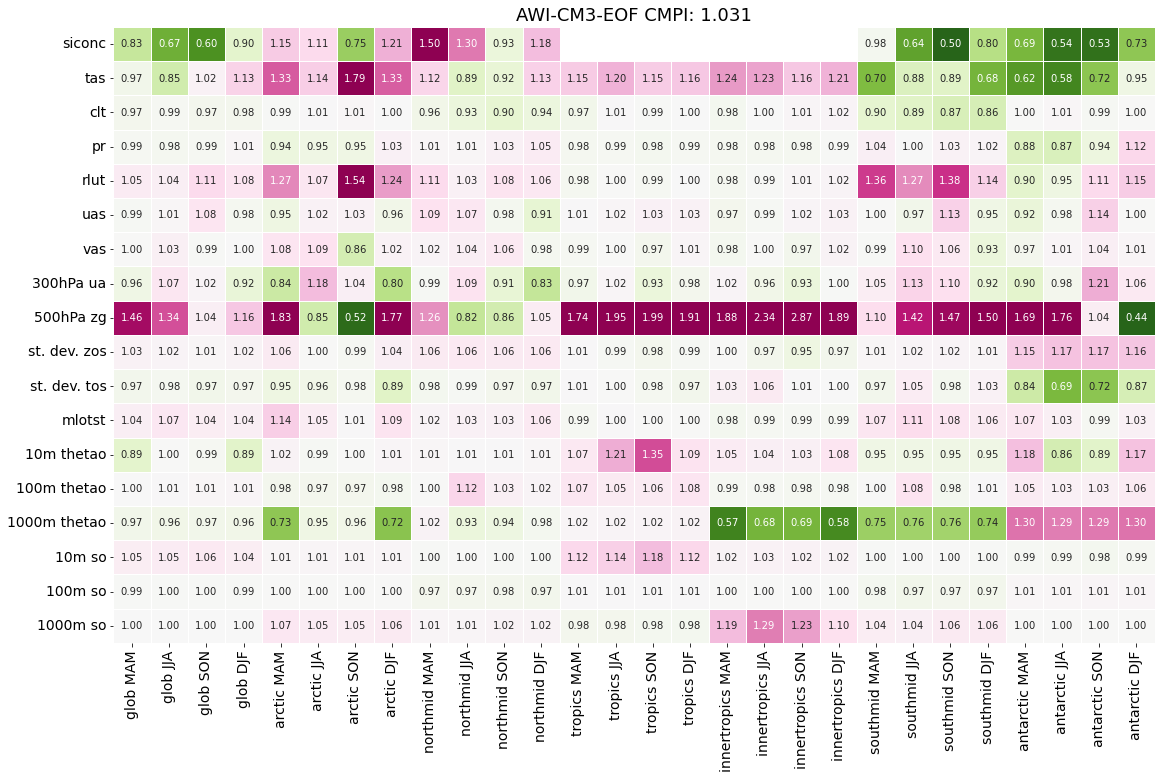

In [82]:
#Read precalculated evaluation field means of errors from csv files and plot heatmap
max_depth=0
for var in var_depths:
    if len(var_depths[var]) > max_depth:
        max_depth = len(var_depths[var])

collect_frac_non = OrderedDict()
for model in models:
    df = pd.read_csv(out_path+'frac/'+model+'_fraction.csv', delimiter=' ')
    values = df['FracMeanError'] #you can also use df['column_name']
    r=0
    for var in obs:
        a=(df['Variable']==var).to_list()
        if any(a): # Check if variable appears in list. If not, skip it.
            print('reading',model,var)
            pass
        else:
            print('skipping',model,var)
            continue
        for region in regions:
            if np.max(np.add(list(map(int, (df['Variable']==var).to_list())),list(map(int, (df['Region']==region).to_list())))) ==2:
                pass
            else:
                #k+=1
                continue
            for depth in np.arange(0,len(var_depths[var])):
                m=0
                for seas in seasons:
                    collect_frac_non[var+' '+var_depths[var][depth],region+' '+seas]=values[r]
                    r+=1


    seasons_plot = [' MAM', ' JJA', ' SON', ' DJF'] #adding spaces in front
    a=seasons_plot*len(regions)
    b=np.repeat(list(regions.keys()),len(seasons_plot))
    coord=[n+str(m) for m,n in zip(a,b)]
    
    index_obs=[]
    for var in models[model]:
        for depth in np.arange(0,len(var_depths[var])):
            if var_depths[var][depth] == 'surface':
                levelname=''
            else:
                levelname=var_depths[var][depth]+' '
            if var == 'zos' or var == 'tos':
                levelname='st. dev. '
            index_obs.append(levelname+var)
    
    collect_frac_reshaped = np.array(list(collect_frac_non.values()) ).reshape(len(index_obs),len(regions)*len(seasons)) # transform to 2D
    collect_frac_dataframe = pd.DataFrame(data=collect_frac_reshaped, index=index_obs, columns=coord)

    fig, ax = plt.subplots(figsize=(28/1.5,17/1.5))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = sns.heatmap(collect_frac_dataframe, vmin=0.5, vmax=1.5,center=1,annot=True,fmt='.2f',cmap="PiYG_r",cbar=False,linewidths=1)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(rotation=0, ha='right',fontsize=14)
    plt.title(model+' CMPI: '+str(round(cmpi[model],3)), fontsize=18)
    
    plt.savefig(out_path+'plot/'+model+'.png',dpi=300,bbox_inches='tight')
    i+=1


In [38]:
#Choose ERA5 or NCEP2. This switch also selects the eval/???? subfolders, so do not mix and match as this would lead to incorrect results.
reanalysis='ERA5'

#Define paths
obs_path='obs/'
model_path='input/'
#model_path='/work/ollie/jstreffi/runtime/awicm3-frontiers/reference/outdata/oifs/combined/'
#model_path='/work/ollie/jstreffi/runtime/awicm3-frontiers/precip_heat_flux_isolated/outdata/oifs/combined/'

out_path='output/'
eval_path='eval/'+reanalysis+'/'
time = '198912-201411'

'''
Define model(s) and the respective variable dicts. (some models dont have the full set of variables available). 
I'd like to write this in a less verbose way, but it seems to involve conversion of string into variable 
via exec() locals() or globals(). I want that even less than long dict def.
'''



obs = { 'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis,
        'thetao':{'10':'EN4','100':'EN4','1000':'EN4','4000':'EN4'},
        'so':{'10':'EN4','100':'EN4','1000':'EN4','4000':'EN4'}}

models = {
    'AWI-CM3-test':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis,
        'so':{'10':'EN4','100':'EN4','1000':'EN4','4000':'EN4'},
        'thetao':{'10':'EN4','100':'EN4','1000':'EN4','4000':'EN4'}
    }
}


'''
eval_models = {
    'AWI-CM3':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis}
}

'''
#Define evaluation models
eval_models = {
    'ACCESS-ESM1-5':{
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'AWI-CM1-MR':{
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'AWI-ESM1-LR':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'BCC':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'CAMS':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'CAS-ESM2-0':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'CAN5':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'CESM2':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':reanalysis,
        'zg':reanalysis},
    'CIESM':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':reanalysis,
        'zg':reanalysis},
    'CMCC-CM2-SR5':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'CNRM6':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'E3SM-1-1':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':reanalysis,
        'zg':reanalysis},
    'EC-Earth3':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'FGOALS-f3-L':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'FGOALS-g3':{
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':reanalysis,
        'zg':reanalysis},
    'FIO2':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP'},
    'GISS-E2-1-G':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'HadGEM3MM':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'HAMMOZ':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'INM5':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'IITM':{
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,},
    'IPSL-CM6A-LR':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'KACE-1-0-G':{
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'KIOST-ESM':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'MCMUA1':{
        'tas':reanalysis,
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'MIROC6':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'MPI-ESM1-2-LR':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'MRI':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'NESM3':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'NORESM2':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':reanalysis,
        'zg':reanalysis},
    'NOAA-GFDL':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis},
    'SNU': {   
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':reanalysis,
        'zg':reanalysis},
    'TAIESM':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'ua':reanalysis,
        'zg':reanalysis},
    'UKESM1-0-LL':{
        'siconc':'OSISAF',
        'tas':reanalysis,
        'clt':'MODIS',
        'pr':'GPCP',
        'rlut':'CERES',
        'uas':reanalysis,
        'vas':reanalysis,
        'ua':reanalysis,
        'zg':reanalysis}
}



#Define regions
regions={'glob' : {
    'lat_min':-90,
    'lat_max':90,},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,}
          
}


#Define seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']

